In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.special import jn_zeros

%load_ext autoreload
%autoreload 2

In [2]:
# Physical parameters
# ======= fixed ==========
L = 1e7 # horizontal length scale; appro radius of polar vortex
period = 9.925*3600  # period of Jupiter rotation
a = 6.99e7 

# ======= derived =========
omega = 2 * np.pi / period 
gamma = 2 * omega / a / a 
a_norm = a / L / 2.0   # dimensionless disk radius

# ======= defined/changed ==========
B1 = 5.18   # L**2/Ld1**2; can vary between 0.1 and 100
# B1 = 51.8   # L**2/Ld1**2; can vary between 0.1 and 100
delta = 1.0 # H2/H1
B2 = delta**2 * B1 # L**2/Ld1**2;
U = 100
Gamma = gamma * (L**3) / U

In [3]:
Gamma - 2 * B1 

-9.64018234181692

In [4]:
def Jmk(m, a_norm, n=1):
    # m is azimuthal wavenumber
    # a_norm is the radius of the domain
    x_zeros = jn_zeros(m, n)
    km_n = x_zeros / a_norm
    return km_n

In [5]:
# calculate the radial wavenumber
nk = 15 # radial wavenumber range 
nm = 15 # azimuthal wavenumber range 
m = np.reshape(np.arange(1, nm+1), (nm, 1))
k = np.empty((nm, nk))
for i in m.flatten():
    k[i-1, :] = Jmk(i, a_norm, n=nk)

# total wavenumber square
l = (k**2) + (m**2)

In [6]:
# a1 * c2 + a2 * c + a3 = 0 to have a solution
a1 = l**2 + (delta**2 + 1) * l * B1
a2 = 2 * l * B1 * (1 - (delta**2)) + 2 * l * Gamma + B1 * (delta**2 + 1) * Gamma
a3 = l * B1 * (1 + (delta**2)) + Gamma * B1 * (1 - (delta**2)) - (l**2) + (Gamma**2)


In [7]:
# solve for wave speed and growth rate
c = np.empty(a1.shape + (2,), dtype=np.complex128)

# Loop through each element of the k array
for i in range(a1.shape[0]):
    for j in range(a1.shape[1]):
        
        # Compute roots and store
        c[i, j, :] = np.roots([a1[i,j], a2[i,j], a3[i,j]])

cr = np.real(c)  # shape (m, n, 2)
ci = np.imag(c)


In [8]:
ci_growth = ci[:,:,0] # positive; (nm, nk)
cp = cr[:,:,1]

ci_colored = np.where(ci_growth > 1e-3, ci_growth * m, np.nan)  # shape: (nm, nk)
x = k.ravel()                    # k: shape (nm, nk), already gridded
y = m.repeat(k.shape[1], axis=1).ravel()  # m: (nm, 1) → repeat to match shape (nm, nk)
c = ci_colored.ravel()
crp = cp.ravel()

In [9]:
# draw the boundary for the instability
instability = ((l**2) - 2 * (B1**2))**2 
thred = 4 * (B1)**4 - (Gamma)**2 * (B1**2)
plt_ins = instability.ravel()

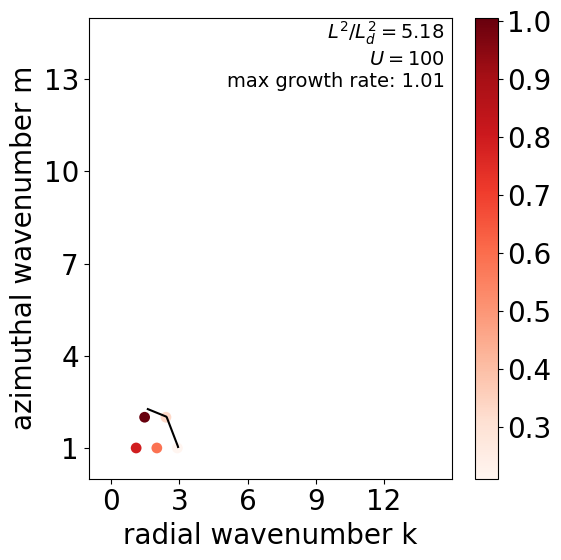

In [10]:
plt.rcParams['font.size'] = 20
# Plot
plt.figure(figsize=(6, 6))
sc = plt.scatter(x, y, c=c, cmap='Reds', edgecolors='none', s=60)
plt.colorbar(sc)
plt.contour(k, m.repeat(k.shape[1], axis=1), instability, levels=[thred], colors='black')
plt.xlabel('radial wavenumber k')
plt.ylabel('azimuthal wavenumber m')
# plt.title('m * ci')
plt.xlim([-1, nk])
plt.ylim([0, nm])
plt.xticks(np.arange(0, nk, 3))
plt.yticks(np.arange(1, nm, 3))
plt.text(
    0.98, 0.84,  # x, y in axes fraction (0–1)
    fr'$L^2/L_d^2 = {B1}$' + '\n' +
    fr'$U = {U}$' + '\n' +
    'max growth rate: '+fr'{np.nanmax(c):.3g}',
    ha='right', va='bottom',
    transform=plt.gca().transAxes,
    fontsize=14
)
plt.tight_layout()
plt.show()

In [11]:
# total wavenumber vs shear



In [12]:
max_idx = np.nanargmax(c)

# Get corresponding values
ci_max = c[max_idx]

m_max = y[max_idx]
k_max = x[max_idx]

max_grow = ci_max
print(f"Max growth rate = {max_grow:.4g} at m = {m_max}, k = {k_max:.4g}")



Max growth rate = 1.006 at m = 2, k = 1.469


In [13]:
# Get corresponding values
cr_max = crp[max_idx]
m_max = y[max_idx]
k_max = x[max_idx]

print(f"Max cr = {cr_max:.4g} at m = {m_max}, k = {k_max:.4g}")


Max cr = -0.08022 at m = 2, k = 1.469


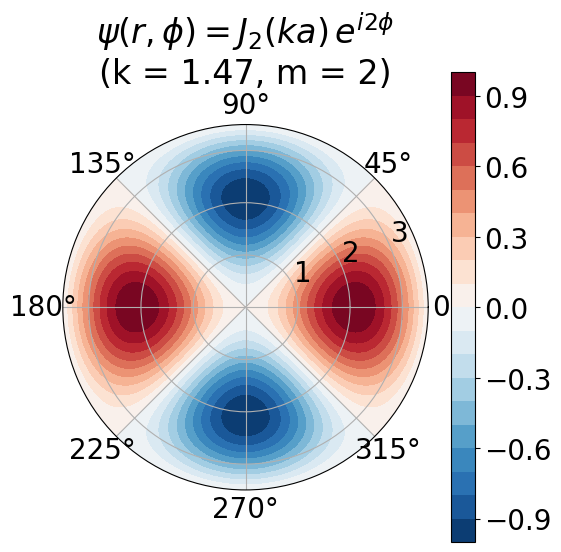

In [14]:
from scipy.special import jv

nr = 200
nphi = 200

r = np.linspace(0, a_norm, nr)
phi = np.linspace(0, 2*np.pi, nphi)

# 2D grid
R, PHI = np.meshgrid(r, phi, indexing='ij')

# Streamfunction mode
m_int = int(m_max)   # m must be integer
psi = jv(m_int, k_max * R) * np.exp(1j * m_int * PHI)
psi_real = np.real(psi)

x = np.reshape(r, (-1,1)) * np.reshape(np.cos(phi), (1,-1))
y = np.reshape(r, (-1,1)) * np.reshape(np.sin(phi), (1,-1))

# Plot in polar coordinates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
contour = ax.contourf(PHI, R, psi_real/np.max(psi_real[:]), levels=20, cmap='RdBu_r')
fig.colorbar(contour)
ax.set_title(fr"$\psi(r, \phi) = J_{{{m_int}}}(k a) \, e^{{i {m_int} \phi}}$" + f"\n(k = {k_max:.2f}, m = {m_int})")
plt.tight_layout()
plt.show()


In [15]:
evp_dir = f'/net/fs06/d0/linyao/GFD_Polar_vortex/ddloutput/EVP/'
fn_evp = f'{evp_dir}EVP_dry_phi_m{m_int}_F{B1}_U{U}.h5'
import h5py 
with h5py.File(fn_evp, "r") as f:
    print("Top-level keys:", list(f.keys()))        # likely includes 'scales' and 'tasks'
    print("Task variables:", list(f["tasks"].keys()))  # e.g., ['psi1', 'psi2']
    psi1_evp = f["tasks/psi1"][:]
    psi2_evp = f["tasks/psi2"][:]
    x_evp = f["tasks/x"][:]
    y_evp = f["tasks/y"][:]
    phi_evp = f["tasks/phi"][:]
    r_evp = f["tasks/r"][:]

PHI_evp, R_evp = np.meshgrid(phi_evp, r_evp, indexing='ij')
# r_evp = np.sqrt(x_evp**2 + y_evp**2)
# phi_evp = np.arctan2(y_evp, x_evp)  # angle in radians

Top-level keys: ['tasks']
Task variables: ['phi', 'psi1', 'psi2', 'r', 'x', 'y']


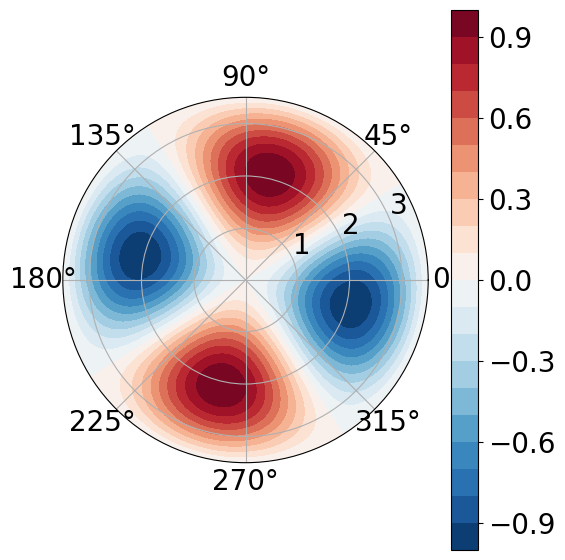

In [16]:

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
contour = ax.contourf(PHI_evp, R_evp, psi1_evp/np.max(psi1_evp[:]), levels=20, cmap='RdBu_r')
fig.colorbar(contour)
# ax.set_title(fr"$\psi(r, \phi) = J_{{{m_int}}}(k a) \, e^{{i {m_int} \phi}}$" + f"\n(k = {k_max:.2f}, m = {m_int})")
plt.tight_layout()
plt.show()


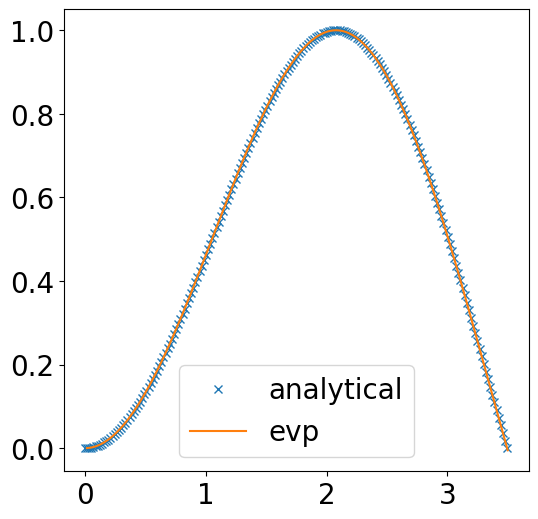

In [17]:
# get the maximum slice of analytical and EVP solutions
nphi_psi1_anl_max = np.argmax(psi_real.sum(axis=0))
psi1_anl_max = psi_real[:, nphi_psi1_anl_max] / np.max(psi_real[:, nphi_psi1_anl_max])

nphi_psi1_evp_max = np.argmax(psi1_evp.sum(axis=1))
psi1_evp_max = psi1_evp[nphi_psi1_evp_max, :] / np.max(psi1_evp[nphi_psi1_evp_max, :])

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(r, psi1_anl_max, 'x', label='analytical')
ax.plot(r_evp.flatten(), psi1_evp_max.flatten(), label='evp')
ax.legend()